# AI CALCULATOR

🎲🎲🎲

This notebook is the baseline solution to classify number and 3 basic mathematics operators, 1 - 10, +,-, and x.

In this example, half of the data is trained. **Your task: FINE TUNE & TRAIN THE WHOLE DATASET**

## IMPORT LIBRARIES

In [34]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
print(tf.__version__) #If not Tensorflow 2 !pip install tensorflow-gpu==2.1.0


import shutil # copy, move file
import os
import pathlib

import random
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.pylab as plt
%matplotlib inline

from collections import Counter

2.1.0-dlenv_tfe


## LOAD DATA

In [36]:
# !unzip complete_data.zip

### Load all image paths

In [37]:
# Path to dataset
data_root = pathlib.Path('./complete_data')
# Find all image's path
all_image_paths = list(data_root.glob("**/*"))

# Check if the path contains file
all_image_paths = [str(path) for path in all_image_paths if path.is_file()]

# Make sure data is well-shuffled
random.shuffle(all_image_paths)

# Count the number of images
image_count = len(all_image_paths)

print(f'There is total {image_count} images.')

There is total 19449 images.


Our folder may contain other files that not image. Cross them out. 

In [4]:
# Read image files and ignore DS_Store
for index, image_path in enumerate(all_image_paths):
    if (image_path.split('.')[1] != "DS_Store") :
        try:
            image = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image, channels=3)
        except:
            print(f'Image {all_image_paths[index]} is not readable.')
        
        if index % 3000 == 0 or index == image_count-1: 
            print(f'Finished scanning {index+1}/{image_count} files.')
    else:
        all_image_paths.remove(image_path)

Image complete_data/5/5_110063.jpg is not readable.
Finished scanning 1/19449 files.
Image complete_data/4/4_16732.jpg is not readable.
Image complete_data/0/0_22938.jpg is not readable.
Image complete_data/10/times_1607.jpg is not readable.
Image complete_data/10/exp19739.jpg is not readable.
Image complete_data/3/3_4057.jpg is not readable.
Image complete_data/1/1_38739.jpg is not readable.
Image complete_data/10/13_16858.jpg is not readable.
Image complete_data/10/exp54859.jpg is not readable.
Image complete_data/1/1_96551.jpg is not readable.
Finished scanning 3001/19449 files.
Image complete_data/10/exp64320.jpg is not readable.
Image complete_data/10/13_16506.jpg is not readable.
Image complete_data/10/times_64439.jpg is not readable.
Image complete_data/9/9_48593.jpg is not readable.
Image complete_data/6/6_1908.jpg is not readable.
Image complete_data/12/exp22963.jpg is not readable.
Image complete_data/12/exp27276.jpg is not readable.
Image complete_data/1/_57802.png is not re

## PREPROCESSING 

### Labels

In [38]:
# Get labels from folder names
label_names = sorted(item.name for item in data_root.glob('**/') if item.is_dir())
label_names = np.array(label_names)

label_names

array(['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9',
       'complete_data'], dtype='<U13')

In [41]:
# Might have to remove unrelevant folders (checkpoint, hidden folders, ...)
# label_names.tolist().remove('.ipynb_checkpoints')
label_names=label_names[:-1]


In [42]:
# Convert into integer 
label_names = label_names.astype(int)
label_names

array([ 0,  1, 10, 11, 12,  2,  3,  4,  5,  6,  7,  8,  9])

In [43]:
# Order the labels so we dont need to remember 
# the order it appears 1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8 ...
label_names.sort()

label_names

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [44]:
# Create dictionary for prediction index to real label (in our case, it happens to be very similar on both side)
label_to_index = dict((str(name), index) for index, name in enumerate(label_names))

label_to_index

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 '10': 10,
 '11': 11,
 '12': 12}

In [45]:
# Find all image's labels from all_image_paths
all_image_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

# get the first 10 lables to check if the random shuffle actually work
print(f"First 10 labels indices: {all_image_labels[:10]}")

First 10 labels indices: [11, 11, 10, 8, 1, 11, 12, 0, 11, 1]


In [46]:
# Count number of images from each class
count = Counter()

for label in all_image_labels:
    count[label_names[label]] += 1

count 

Counter({11: 3042,
         10: 3771,
         8: 704,
         1: 1435,
         12: 2927,
         0: 1266,
         5: 909,
         2: 901,
         6: 1614,
         4: 993,
         7: 529,
         3: 814,
         9: 544})

### Images

In [47]:
def load_and_preprocess_image(path):
    """ Read and process images into grayscale, resized, and standardized.
    """
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image, [28, 28])
    image = (255 - image)/255.0 #Normalize and invert image
    
    return image

def load_and_preprocess_from_path_label(path, label):
    return load_and_preprocess_image(path), label

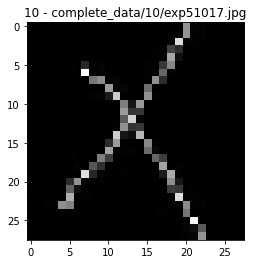

In [48]:
# Visualize training images
index = random.randint(0, image_count)
image_path = all_image_paths[index]
label = all_image_labels[index]

# Show image
plt.imshow(load_and_preprocess_image(image_path)[:,:,0], cmap='gray')
plt.grid(False)
plt.title(f'{label_names[label]} - {image_path}')
plt.show()

In [49]:
# split the data for train set and test set
train_image_paths, test_image_paths, train_image_labels, test_image_labels = train_test_split(all_image_paths, 
                                                                                              all_image_labels, 
                                                                                              test_size=0.2, 
                                                                                              random_state=101)

In [50]:
print(f'Training set contains {len(train_image_paths)} images.')
print(f'Testing set contains {len(test_image_paths)} images.')

Training set contains 15559 images.
Testing set contains 3890 images.


## CREATE DATASET

In [51]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

def create_ds(all_image_paths, all_image_labels):
    
    # prepare the dataset for pipeline with tensor_slices
    ds = tf.data.Dataset.from_tensor_slices((all_image_paths, all_image_labels))
    
    # map the load_and_preprocess_from_path_label function to the pipeline
    image_label_ds = ds.map(load_and_preprocess_from_path_label)

    # Setting a shuffle buffer size as large as the dataset ensures that the data is 
    # well-shuffled, so the order of training will be different for every epoch.
    ds = image_label_ds.cache().shuffle(buffer_size=image_count).repeat().batch(BATCH_SIZE)
    # `prefetch` lets the dataset fetch batches in the background while the model is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

In [52]:
# create dataset for train set and test set
train_ds = create_ds(train_image_paths, train_image_labels)
test_ds = create_ds(test_image_paths, test_image_labels)

In [53]:
train_ds 

<PrefetchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int32)>

## MODEL

In [54]:
def build_model():
    model = tf.keras.Sequential([   
          tf.keras.layers.Conv2D(kernel_size=3, filters=12, use_bias=False, padding='same', input_shape=(28, 28, 1),activation='relu'),
          tf.keras.layers.MaxPooling2D(pool_size= 2),
          tf.keras.layers.BatchNormalization(center=True, scale=False),
          tf.keras.layers.Dropout(0.2),        

          tf.keras.layers.Conv2D(kernel_size=6, filters=24, use_bias=False, padding='same', strides=2,activation='relu'),
          tf.keras.layers.MaxPooling2D(pool_size= 2),
          tf.keras.layers.BatchNormalization(center=True, scale=False),
          tf.keras.layers.Dropout(0.2),
        
          tf.keras.layers.Conv2D(kernel_size=6, filters=48, use_bias=False, padding='same', strides=2,activation='relu'),
          tf.keras.layers.MaxPooling2D(pool_size= 2),
          tf.keras.layers.BatchNormalization(center=True, scale=False),
          tf.keras.layers.Dropout(0.25),
        
          tf.keras.layers.GlobalAveragePooling2D(),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(48, use_bias=False,activation='relu'),
          tf.keras.layers.BatchNormalization(center=True, scale=False),
          tf.keras.layers.Dropout(0.5),
        
          tf.keras.layers.Dense(len(label_names), activation='softmax')
      ])
    
    return model

In [55]:
cnn_model = build_model()
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 12)        108       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 12)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 12)        36        
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 24)          10368     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 24)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 24)          7

In [56]:
cnn_model.compile(optimizer=tf.keras.optimizers.Nadam(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

## TRAIN

### Callbacks

In [57]:
# Batch Stats Collector that inherits Keras Callback
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
        self.batch_val_losses = []
        self.batch_val_acc = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['accuracy'])
        # reset_metrics: the metrics returned will be only for this batch. 
        # If False, the metrics will be statefully accumulated across batches.
        self.model.reset_metrics()
  
    def on_test_batch_end(self, batch, logs=None):
        self.batch_val_losses.append(logs['loss'])
        self.batch_val_acc.append(logs['accuracy'])
        # reset_metrics: the metrics returned will be only for this batch. 
        # If False, the metrics will be statefully accumulated across batches.
        self.model.reset_metrics()

# Plot learning curve 
def plot_stats(training_stats, val_stats, x_label='Training Steps', stats='loss'):
    stats, x_label = stats.title(), x_label.title()
    legend_loc = 'upper right' if stats=='loss' else 'lower right'
    training_steps = len(training_stats)
    test_steps = len(val_stats)

    plt.figure()
    plt.ylabel(stats)
    plt.xlabel(x_label)
    plt.plot(training_stats, label='Training ' + stats)
    plt.plot(np.linspace(0, training_steps, test_steps), val_stats, label='Validation ' + stats)
    plt.ylim([0,max(plt.ylim())])
    plt.legend(loc=legend_loc)
    plt.show()

### Train Session

In [58]:
# Calculate the number of steps to finish one epoch
steps_per_epoch = len(train_image_labels) // BATCH_SIZE
val_steps_per_epoch = len(test_image_labels) // BATCH_SIZE

# Define callback
batch_stats_callback = CollectBatchStats()

In [59]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3,mode='min',verbose=1,restore_best_weights=True)
reducing_lr = tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-5,factor=0.1,patience=1,verbose=1)

max_epochs = 50

history = cnn_model.fit(train_ds, 
                        epochs=max_epochs, 
                        steps_per_epoch=steps_per_epoch,
                        callbacks = [batch_stats_callback,early_stopping,reducing_lr],
                        validation_data=test_ds,
                        validation_steps=val_steps_per_epoch)

Train for 486 steps, validate for 121 steps
Epoch 1/50
486/486 [==============================] - 12s 24ms/step - loss: 0.9686 - accuracy: 0.8750 - val_loss: 0.2918 - val_accuracy: 0.9062
Epoch 2/50
486/486 [==============================] - 3s 7ms/step - loss: 0.3546 - accuracy: 0.8125 - val_loss: 0.0887 - val_accuracy: 1.0000
Epoch 3/50
486/486 [==============================] - 3s 7ms/step - loss: 0.2214 - accuracy: 0.9062 - val_loss: 0.0545 - val_accuracy: 1.0000
Epoch 4/50
486/486 [==============================] - 3s 7ms/step - loss: 0.1674 - accuracy: 0.9375 - val_loss: 0.0409 - val_accuracy: 1.0000
Epoch 5/50
486/486 [==============================] - 3s 7ms/step - loss: 0.1412 - accuracy: 0.9688 - val_loss: 0.0392 - val_accuracy: 0.9688
Epoch 6/50
486/486 [==============================] - 3s 7ms/step - loss: 0.1114 - accuracy: 1.0000 - val_loss: 0.0305 - val_accuracy: 0.9688
Epoch 7/50
486/486 [==============================] - 3s 7ms/step - loss: 0.0979 - accuracy: 0.9688 - 

<Figure size 1080x720 with 0 Axes>

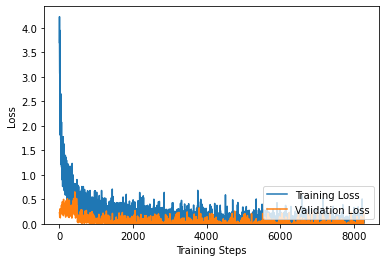

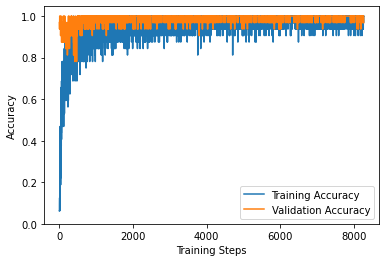

In [60]:
# Visualize training session on batch 
plt.figure(figsize = (15, 10))

plot_stats(batch_stats_callback.batch_losses, batch_stats_callback.batch_val_losses, stats='loss')
plot_stats(batch_stats_callback.batch_acc, batch_stats_callback.batch_val_acc, stats='accuracy')

<Figure size 1080x720 with 0 Axes>

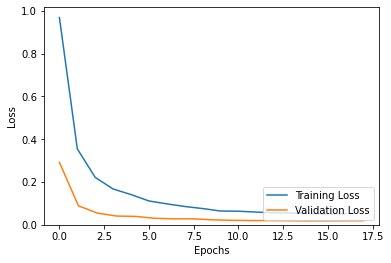

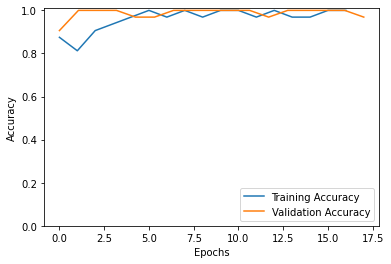

In [61]:
plt.figure(figsize = (15, 10))

plot_stats(history.history['loss'], history.history['val_loss'], x_label='Epochs', stats='loss')
plot_stats(history.history['accuracy'], history.history['val_accuracy'], x_label='Epochs', stats='accuracy');

## Testing and preview

In [62]:
# Take one batch to predict

for image_batch, label_batch in test_ds.take(1):
    print("Image batch shape: ", image_batch.shape)
    print("Label batch shape: ", label_batch.shape)

Image batch shape:  (32, 28, 28, 1)
Label batch shape:  (32,)


In [63]:
# Prediction 
predicted_batch = cnn_model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=1)
predicted_label_batch = label_names[predicted_id]

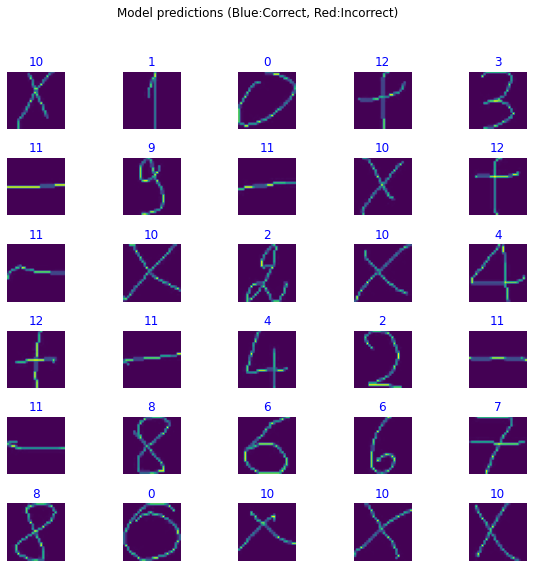

In [64]:
# Plot the result
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n][:,:,0])
    color = "blue" if predicted_id[n] == label_batch.numpy()[n] else "red"
    plt.title(predicted_label_batch[n], color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (Blue:Correct, Red:Incorrect)")

## Export model

In [65]:
# Export model
cnn_model.save('complete.h5')

In [66]:
!pwd

/home/jupyter/MultipleDigitsClassifier/i_love_maths_exercise/model_ml


In [67]:
# Test model
reloaded_model = tf.keras.models.load_model('complete.h5')
reloaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 12)        108       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 12)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 12)        36        
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 24)          10368     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 24)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 24)          7

In [68]:
# test if the current model result and export model result is consistent
result_batch = cnn_model.predict(image_batch)
reloaded_result_batch = reloaded_model.predict(image_batch)

In [69]:
# check if there is any difference, we expect 0.0 as result
abs(reloaded_result_batch - result_batch).max()

0.0